## Uczenie maszynowe UMZ 2019/2020
### 28 kwietnia 2020
# 7. Algorytm $k$ najbliższych sąsiadów

### KNN – intuicja

* Do której kategorii powinien należeć punkt oznaczony gwiazdką?

In [1]:
# Przydatne importy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas

%matplotlib inline

In [2]:
# Wczytanie danych (gatunki kosaćców)

data_iris = pandas.read_csv('iris.csv')
data_iris_setosa = pandas.DataFrame()
data_iris_setosa['dł. płatka'] = data_iris['pl']  # "pl" oznacza "petal length"
data_iris_setosa['szer. płatka'] = data_iris['pw']  # "pw" oznacza "petal width"
data_iris_setosa['Iris setosa?'] = data_iris['Gatunek'].apply(lambda x: 1 if x=='Iris-setosa' else 0)

m, n_plus_1 = data_iris_setosa.values.shape
n = n_plus_1 - 1
Xn = data_iris_setosa.values[:, 0:n].reshape(m, n)

X = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
Y = np.matrix(data_iris_setosa.values[:, 2]).reshape(m, 1)

In [3]:
# Wykres danych (wersja macierzowa)
def plot_data_for_classification(X, Y, xlabel, ylabel):    
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    X = X.tolist()
    Y = Y.tolist()
    X1n = [x[1] for x, y in zip(X, Y) if y[0] == 0]
    X1p = [x[1] for x, y in zip(X, Y) if y[0] == 1]
    X2n = [x[2] for x, y in zip(X, Y) if y[0] == 0]
    X2p = [x[2] for x, y in zip(X, Y) if y[0] == 1]
    ax.scatter(X1n, X2n, c='r', marker='x', s=50, label='Dane')
    ax.scatter(X1p, X2p, c='g', marker='o', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    return fig

In [4]:
def plot_new_example(fig, x, y):
    ax = fig.axes[0]
    ax.scatter([x], [y], c='k', marker='*', s=100, label='?')

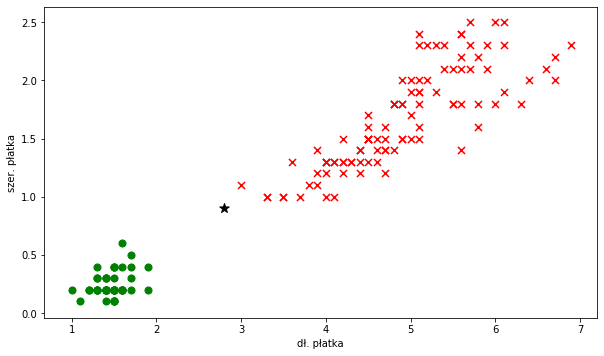

In [5]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_new_example(fig, 2.8, 0.9)

* Wydaje się sensownym przyjąć, że punkt oznaczony gwiazdką powinien być czerwony, ponieważ sąsiednie punkty są czerwone. Najbliższe czerwone punkty są położone bliżej niż najbliższe zielone.

* Algorytm oparty na tej intuicji nazywamy algorytmem **$k$ najbliższych sąsiadów** (_$k$ nearest neighbors_, KNN).

* Idea (KNN dla $k = 1$):
  1. Dla nowego przykładu $x'$ znajdź najbliższy przykład $x$ ze zbioru uczącego.
  1. Jego klasa $y$ to szukana klasa $y'$.

In [6]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_voronoi(fig, points):
    ax = fig.axes[0]
    vor = Voronoi(points)
    ax.scatter(vor.vertices[:, 0], vor.vertices[:, 1], s=1)
    
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1],
                    color='orange', linewidth=1)
    
    xmin, ymin = points.min(axis=0).tolist()[0]
    xmax, ymax = points.max(axis=0).tolist()[0]
    pad = 0.1
    ax.set_xlim(xmin - pad, xmax + pad)
    ax.set_ylim(ymin - pad, ymax + pad)

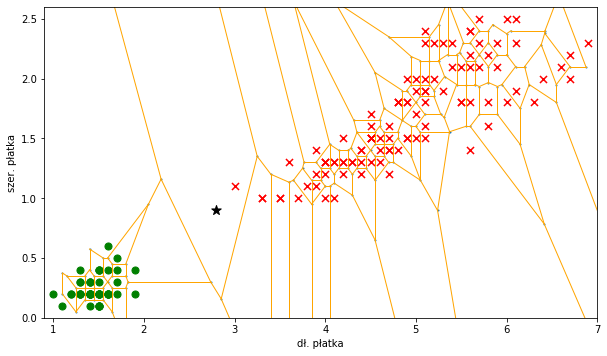

In [7]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_new_example(fig, 2.8, 0.9)
plot_voronoi(fig, X[:, 1:])

* Podział płaszczyzny jak na powyższym wykresie nazywamy **diagramem Woronoja** (_Voronoi diagram_).

* Taki algorytm wyznacza dość efektowne granice klas, zwłaszcza jak na tak prosty algorytm. 

* Niestety jest bardzo podatny na obserwacje odstające:

In [8]:
X_outliers = np.vstack((X, np.matrix([[1.0, 3.9, 1.7]])))
Y_outliers = np.vstack((Y, np.matrix([[1]])))

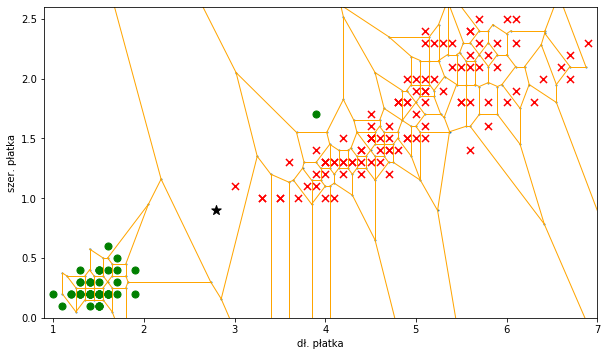

In [9]:
fig = plot_data_for_classification(X_outliers, Y_outliers, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_new_example(fig, 2.8, 0.9)
plot_voronoi(fig, X_outliers[:, 1:])

* Pojedyncza obserwacja odstająca dramatycznie zmienia granice klas.

* Aby temu zaradzić, użyjemy więcej niż jednego najbliższego sąsiada ($k > 1$).

### Algorytm $k$ najbliższych sąsiadów dla problemu klasyfikacji

1. Dany jest zbiór uczący zawierajacy przykłady $(x_i, y_i)$, gdzie: $x_i$ – zestaw cech, $y_i$ – klasa.
1. Dany jest przykład testowy $x'$, dla którego chcemy określić klasę.
1. Oblicz odległość $d(x', x_i)$ dla każdego przykładu $x_i$ ze zbioru uczącego.
1. Wybierz $k$ przykładów $x_{i_1}, \ldots, x_{i_k}$, dla których wyliczona odległość jest najmniejsza.
1. Jako wynik $y'$ zwróć tę spośrod klas $y_{i_1}, \ldots, y_{i_k}$, która występuje najczęściej.

### Algorytm $k$ najbliższych sąsiadów dla problemu klasyfikacji – przykład

In [10]:
# Odległość euklidesowa
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

In [11]:
# Algorytm k najbliższych sąsiadów
def knn(X, Y, x_new, k, distance=euclidean_distance):
    data = np.concatenate((X, Y), axis=1)
    nearest = sorted(
        data, key=lambda xy:distance(xy[0, :-1], x_new))[:k]
    y_nearest = [xy[0, -1] for xy in nearest]
    return max(y_nearest, key=lambda y:y_nearest.count(y))

In [12]:
# Wykres klas dla KNN
def plot_knn(fig, X, Y, k, distance=euclidean_distance):
    ax = fig.axes[0]
    x1min, x2min = X.min(axis=0).tolist()[0]
    x1max, x2max = X.max(axis=0).tolist()[0]
    pad1 = (x1max - x1min) / 10
    pad2 = (x2max - x2min) / 10
    step1 = (x1max - x1min) / 50
    step2 = (x2max - x2min) / 50
    x1grid, x2grid = np.meshgrid(
        np.arange(x1min - pad1, x1max + pad1, step1),
        np.arange(x2min - pad2, x2max + pad2, step2))
    z = np.matrix([[knn(X, Y, [x1, x2], k, distance) 
                    for x1, x2 in zip(x1row, x2row)] 
                   for x1row, x2row in zip(x1grid, x2grid)])
    plt.contour(x1grid, x2grid, z, levels=[0.5]);

In [13]:
# Przygotowanie interaktywnego wykresu

slider_k = widgets.IntSlider(min=1, max=10, step=1, value=1, description=r'$k$', width=300)

def interactive_knn_1(k):
    fig = plot_data_for_classification(X_outliers, Y_outliers, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
    plot_voronoi(fig, X_outliers[:, 1:])
    plot_knn(fig, X_outliers[:, 1:], Y_outliers, k)

In [14]:
widgets.interact_manual(interactive_knn_1, k=slider_k)

interactive(children=(IntSlider(value=1, description='$k$', max=10, min=1), Button(description='Run Interact',…

<function __main__.interactive_knn_1(k)>

In [15]:
# Wczytanie danych (inny przykład)

alldata = pandas.read_csv('classification.tsv', sep='\t')
data = np.matrix(alldata)

m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 1:].reshape(m, n)

X2 = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
Y2 = np.matrix(data[:, 0]).reshape(m, 1)

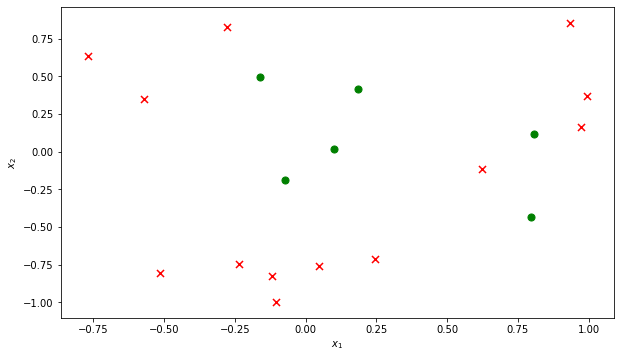

In [16]:
fig = plot_data_for_classification(X2, Y2, xlabel=r'$x_1$', ylabel=r'$x_2$')

In [17]:
# Przygotowanie interaktywnego wykresu

slider_k = widgets.IntSlider(min=1, max=10, step=1, value=1, description=r'$k$', width=300)

def interactive_knn_2(k):
    fig = plot_data_for_classification(X2, Y2, xlabel=r'$x_1$', ylabel=r'$x_2$')
    plot_voronoi(fig, X2[:, 1:])
    plot_knn(fig, X2[:, 1:], Y2, k)

In [18]:
widgets.interact_manual(interactive_knn_2, k=slider_k)

interactive(children=(IntSlider(value=1, description='$k$', max=10, min=1), Button(description='Run Interact',…

<function __main__.interactive_knn_2(k)>

### Algorytm $k$ najbliższych sąsiadów dla problemu regresji

1. Dany jest zbiór uczący zawierajacy przykłady $(x_i, y_i)$, gdzie: $x_i$ – zestaw cech, $y_i$ – liczba rzeczywista.
1. Dany jest przykład testowy $x'$, dla którego chcemy określić klasę.
1. Oblicz odległość $d(x', x_i)$ dla każdego przykładu $x_i$ ze zbioru uczącego.
1. Wybierz $k$ przykładów $x_{i_1}, \ldots, x_{i_k}$, dla których wyliczona odległość jest najmniejsza.
1. Jako wynik $y'$ zwróć średnią liczb $y_{i_1}, \ldots, y_{i_k}$:
   $$ y' = \frac{1}{k} \sum_{j=1}^{k} y_{i_j} $$

### Wybór $k$

* Wartość $k$ ma duży wpływ na wynik działania algorytmu KNN:
  * Jeżeli $k$ jest zbyt duże, wszystkie nowe przykłady są klasyfikowane jako klasa większościowa.
  * Jeżeli $k$ jest zbyt małe, granice klas są niestabilne, a algorytm jest bardzo podatny na obserwacje odstające.
* Aby dobrać optymalną wartość $k$, najlepiej użyć zbioru walidacyjnego.

### Miary podobieństwa

#### Odległość euklidesowa
$$ d(x, x') = \sqrt{ \sum_{i=1}^n \left( x_i - x'_i \right) ^2 } $$

* Dobry wybór w przypadku numerycznych cech.
* Symetryczna, traktuje wszystkie wymiary jednakowo.
* Wrażliwa na duże wahania jednej cechy.

#### Odległość Hamminga
$$ d(x, x') = \sum_{i=1}^n \mathbf{1}_{x_i \neq x'_i} $$

* Dobry wybór w przypadku cech zero-jedynkowych.
* Liczba cech, którymi różnią się dane przykłady.

#### Odległość Minkowskiego ($p$-norma)
$$ d(x, x') = \sqrt[p]{ \sum_{i=1}^n \left| x_i - x'_i \right| ^p } $$

* Dla $p = 2$ jest to odległość euklidesowa.
* Dla $p = 1$ jest to odległość taksówkowa.
* Jeżeli $p \to \infty$, to $p$-norma zbliża się do logicznej alternatywy.
* Jeżeli $p \to 0$, to $p$-norma zbliża się do logicznej koniunkcji.

### KNN – praktyczne porady

* Co zrobić z remisami?
  * Można wybrać losową klasę.
  * Można wybrać klasę o wyższym prawdopodobieństwie _a priori_.
  * Można wybrać klasę wskazaną przez algorytm 1NN.

* KNN źle radzi sobie z brakującymi wartościami cech (nie można wówczas sensownie wyznaczyć odległości).